**Load Tools and Configs**

In [ ]:
from tools.tools_lookup_policy import lookup_policy
from tools.tools_flights import fetch_user_flight_information, search_flights, update_ticket_to_new_flight, cancel_ticket
from tools.tools_hotels import search_hotels, book_hotel, update_hotel, cancel_hotel
from tools.tools_excursions import search_trip_recommendations, book_excursion, update_excursion, cancel_excursion
from tools.tools_car_rental import search_car_rentals, book_car_rental, update_car_rental, cancel_car_rental
from utils.utilities import create_tool_node_with_fallback, _print_event
from utils.load_notebook_config import LoadConfig

CFG = LoadConfig()

**Load the LLM**

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

**Define the State**

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

**Define the Assistant:** This class takes the graph state, formats it into a prompt, and then calls an LLM for it to predict the best response.

In [ ]:
from langchain_core.runnables import Runnable, RunnableConfig

class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            passenger_id = configuration.get("passenger_id", None)
            state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

**Define the Primary Agent's System Role**

In [ ]:
from datetime import datetime
from langchain_core.prompts import ChatPromptTemplate

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

**Wrap Up the Tools and Bind Them to the Primary Agent (LLM)**

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
    search_car_rentals,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    search_hotels,
    book_hotel,
    update_hotel,
    cancel_hotel,
    search_trip_recommendations,
    book_excursion,
    update_excursion,
    cancel_excursion,
]
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

**Define the Graph** (Adding nodes and edges)

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")

# Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end.
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

**Save the Image ```(if save=True)```**

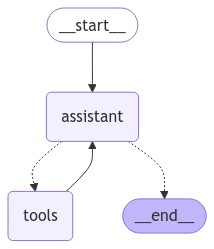

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

**Save the Image ```(if save=True)```**

In [9]:
save = False
image_name = "bot_zero_shot.png"

if save:
    from PIL import Image as PILImage
    import io
    # Assuming graph.get_graph().draw_mermaid_png() returns PNG binary data
    try:
        # Generate the PNG image from the graph
        png_data = graph.get_graph().draw_mermaid_png()
        
        # Convert the binary data into an image
        img = PILImage.open(io.BytesIO(png_data))
        
        # Save the image locally with 300 DPI
        img.save(image_name, 'PNG', dpi=(300, 300))
        
        print("Image saved successfully with 300 DPI.")
    except Exception as e:
        print(f"Error: {e}")

Image saved successfully with 300 DPI.


**Sample Questions**

In [3]:
# Let's create an example conversation a user might have with the assistant
sample_questions = [
    # "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    # "Update my flight to sometime next week then",
    # "The next available option is great",
    # "what about lodging and transportation?",
    # "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    # "OK could you place a reservation for your recommended hotel? It sounds nice.",
    # "yes go ahead and book anything that's moderate expense and has availability.",
    # "Now for a car, what are my options?",
    # "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    # "Cool so now what recommendations do you have on excursions?",
    # "Are they available while I'm there?",
    # "interesting - i like the museums, what options are there? ",
    # "OK great pick one and book it for my second day there.",
]

**Prepare the Databases and Configure Settings for a Sample User**

In [2]:
from utils.utilities import update_dates
import uuid

# Update with the backup file so we can restart from the original place in each section
db = update_dates(CFG.local_file, CFG.backup_file)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

**Test the Bot**

In [ ]:
_printed = set()
for question in sample_questions:
    events = graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

------------------------------------------------
## **Problems**

Here are the general problems of the assistant bot identified from the text:

1. **Premature or Unwanted Actions**: The assistant may perform an action prematurely or unrelated to the user's immediate focus. This can lead to unwanted outcomes and confusion for the user. The assistant should make sure that the user has the final approval before taking an important action.

2. **Struggles with Tool Usage**: The assistant has difficulty using tools effectively. This may indicate a need for better understanding or guidance on how to use tools, but providing verbose instructions for every tool risks overwhelming the bot and reducing its efficiency.

3. **Inefficient Data Retrieval**: The assistant had to perform an explicit search to gather relevant user information, which could have been fetched earlier. This results in inefficient interactions, as time is wasted searching for information that could be preloaded or readily available.

These issues point to concerns around control, tool management, and efficient handling of user data.

------------------------------------------------